# Weather-based Forecasting of Solar Power Generation in Germany

## 1. Introduction

This project investigates whether weather data (such as solar radiation and temperature) can be used to predict solar power generation in Germany using a LSTM model. 
Accurate forecasting of solar power generation is essential for integrating renewable energy, ensuring grid stability, and supporting operational planning. To achieve this, open datasets and a neural network approach will be employed.

### Table of Contents

1. Introduction  
2. Data Sources  
3. Data Preparation  
   3.1 Feature Engineering  
4. Exploratory Data Analysis and Visualisations  
   4.1 Visualisations  
       4.1.1 Heatmap: Correlations between Solar Generation, Radiation and Temperature  
       4.1.2 Time Series Plot: Solar Production from 2015 - 2019  
       4.1.3 Time Series Plot: Mean Solar Generation per Day  
       4.1.4 Time Series Plot: Mean Solar Generation per Month  
5. Data Preparation for Creation of Model  
   5.1 Normalization of Data  
6. Modelling Approach: LSTM  
   6.1 Initialisation of LSTM Model  
   6.2 Evaluation of Initial Model  
   6.3 Visualisation: Prognosis vs. Actual Data  
   6.4 Hyperparameter Tuning: Updated Model  
   6.5 Evaluation of Updated Model  
   6.6 Final Evaluation  
7. Conclusion and Outlook

## 2. Data Sources

The weather data was taken from: https://data.open-power-system-data.org/weather_data/2020-09-16
This data package contains radiation and temperature data, at hourly resolution, for Europe, aggregated by Renewables.ninja from the NASA MERRA-2 reanalysis. It covers the European countries using a population-weighted mean across all MERRA-2 grid cells within the given country.



The data on solar power generation was taken from: https://data.open-power-system-data.org/time_series/2020-10-06
This data package contains different kinds of timeseries data relevant for power system modelling, namely electricity prices, electricity consumption (load) as well as wind and solar power generation and capacities. 
The data is aggregated either by country, control area or bidding zone. Geographical coverage includes the EU and some neighbouring countries. All variables are provided in hourly resolution. Where original data is available in higher resolution (half-hourly or quarter-hourly), it is provided in separate files. This package version only contains data provided by TSOs and power exchanges via ENTSO-E Transparency, covering the period 2015-mid 2020. See previous versions for historical data from a broader range of sources. 

## 3. Data Preparation

This section imports the German weather dataset and the solar power time series dataset. The relevant weather features (temperature and radiation) and solar power measurements are extracted. Missing values are handled, and the aggregated solar generation is verified against individual grid operators. The two datasets are then merged on `utc_timestamp`, restricted to the period 2014-12-31 23:00:00 until 2019-12-31 23:00:00, and time-based features (hour and month )are added. 


In [1]:
# Import required libraries
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimpy import skim
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # 0=alle, 1=INFO, 2=WARNING, 3=ERROR
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [2]:
# Set seeds to ensure reproducability of results and metrics
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
# Import and preview weather dataset
weather_df = pd.read_csv('path/to/file/weather_data.csv', parse_dates=['utc_timestamp'])
weather_df.head()
weather_df.columns

Index(['utc_timestamp', 'AT_temperature', 'AT_radiation_direct_horizontal',
       'AT_radiation_diffuse_horizontal', 'BE_temperature',
       'BE_radiation_direct_horizontal', 'BE_radiation_diffuse_horizontal',
       'BG_temperature', 'BG_radiation_direct_horizontal',
       'BG_radiation_diffuse_horizontal', 'CH_temperature',
       'CH_radiation_direct_horizontal', 'CH_radiation_diffuse_horizontal',
       'CZ_temperature', 'CZ_radiation_direct_horizontal',
       'CZ_radiation_diffuse_horizontal', 'DE_temperature',
       'DE_radiation_direct_horizontal', 'DE_radiation_diffuse_horizontal',
       'DK_temperature', 'DK_radiation_direct_horizontal',
       'DK_radiation_diffuse_horizontal', 'EE_temperature',
       'EE_radiation_direct_horizontal', 'EE_radiation_diffuse_horizontal',
       'ES_temperature', 'ES_radiation_direct_horizontal',
       'ES_radiation_diffuse_horizontal', 'FI_temperature',
       'FI_radiation_direct_horizontal', 'FI_radiation_diffuse_horizontal',
       '

In [4]:
# Import and preview time series data
time_series_df = pd.read_csv('path/to/file/weather_data.csv', parse_dates=['utc_timestamp'])
time_series_df.head()
print(list(time_series_df.columns))

['utc_timestamp', 'cet_cest_timestamp', 'AT_load_actual_entsoe_transparency', 'AT_load_forecast_entsoe_transparency', 'AT_price_day_ahead', 'AT_solar_generation_actual', 'AT_wind_onshore_generation_actual', 'BE_load_actual_entsoe_transparency', 'BE_load_forecast_entsoe_transparency', 'BE_solar_generation_actual', 'BE_wind_generation_actual', 'BE_wind_offshore_generation_actual', 'BE_wind_onshore_generation_actual', 'BG_load_actual_entsoe_transparency', 'BG_load_forecast_entsoe_transparency', 'BG_solar_generation_actual', 'BG_wind_onshore_generation_actual', 'CH_load_actual_entsoe_transparency', 'CH_load_forecast_entsoe_transparency', 'CH_solar_capacity', 'CH_solar_generation_actual', 'CH_wind_onshore_capacity', 'CH_wind_onshore_generation_actual', 'CY_load_actual_entsoe_transparency', 'CY_load_forecast_entsoe_transparency', 'CY_wind_onshore_generation_actual', 'CZ_load_actual_entsoe_transparency', 'CZ_load_forecast_entsoe_transparency', 'CZ_solar_generation_actual', 'CZ_wind_onshore_ge

In [5]:
# Extract weather data and timestamps for Germany
weather_de_df = weather_df[[
    'utc_timestamp',
    'DE_temperature',
    'DE_radiation_direct_horizontal',
    'DE_radiation_diffuse_horizontal'
]]
weather_de_df.head()
skim(weather_de_df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ Dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 350640 │ │ float64     │ 3     │                                                          │
│ │ Number of columns │ 4      │ │ datetime64  │ 1     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┓  │
│ ┃ column                 ┃ NA  ┃ NA %  ┃ mean   ┃ sd     ┃ p0      ┃ p25   ┃ p50    ┃ p75   ┃ p100  ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━┩  │
│ │ DE_temperature         │   0 │     0 │  8.786 │  8.154 │  -19.81 │ 2.452 │  8.568 │ 14.92 │ 35.48 │  ▂██▃  │  │
│ │ DE_radiation_direct_ho │   0 │     0 │  77.78 │  153.1 │       0 │     0 │ 0.3699 │  70.4 │   850 │   █▁   │  │
│ │ rizontal               │     │       │        │        │         │       │        │       │       │        │  │
│ │ DE_radiation_diffuse_h │   0 │     0 │  69.08 │  91.87 │       0 │     0 │  6.324 │ 123.7 │ 397.8 │  █▂▁▁  │  │
│ │ orizontal              │     │       │        │        │         │       │        │       │       │        │  │
│ └────────────────────────┴─────┴───────┴────────┴────────┴─────────┴───────┴────────┴───────┴───────┴────────┘  │
│                                                    datetime                                                     │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓  │
│ ┃ column                ┃ NA   ┃ NA %    ┃ first            ┃ last                          ┃ frequency      ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩  │
│ │ utc_timestamp         │    0 │       0 │    1980-01-01    │      2019-12-31 23:00:00      │ h              │  │
│ └───────────────────────┴──────┴─────────┴──────────────────┴───────────────────────────────┴────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

In [6]:
# Fill missing values in time_series_df with 0
time_series_df['DE_solar_generation_actual'] = time_series_df['DE_solar_generation_actual'].fillna(0)
time_series_df['DE_50hertz_solar_generation_actual'] = time_series_df['DE_50hertz_solar_generation_actual'].fillna(0)
time_series_df['DE_amprion_solar_generation_actual'] = time_series_df['DE_amprion_solar_generation_actual'].fillna(0)
time_series_df['DE_tennet_solar_generation_actual'] = time_series_df['DE_tennet_solar_generation_actual'].fillna(0)
time_series_df['DE_transnetbw_solar_generation_actual'] = time_series_df['DE_transnetbw_solar_generation_actual'].fillna(0)

In [7]:
# Check whether column 'DE_solar_generation_actual' is the aggregated data of the four grid operators: 
grid_operators = time_series_df['DE_50hertz_solar_generation_actual'] + time_series_df['DE_amprion_solar_generation_actual']+ time_series_df['DE_tennet_solar_generation_actual'] + time_series_df['DE_transnetbw_solar_generation_actual']

diff = time_series_df['DE_solar_generation_actual'] - grid_operators
diff
# As 'DE_solar_generation_actual' is the aggregated capacity of all four grid operators, 
#this column will be used for the following analysis

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
50396    0.0
50397    0.0
50398    0.0
50399    0.0
50400    0.0
Length: 50401, dtype: float64

In [8]:
# Extract data on solar power and timestamps for Germany
solar_de_df = time_series_df [[
    'utc_timestamp',
    'DE_solar_generation_actual',
    'DE_solar_capacity', 
]]
solar_de_df.head()
skim(solar_de_df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ Dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 50401  │ │ float64     │ 2     │                                                          │
│ │ Number of columns │ 3      │ │ datetime64  │ 1     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┓  │
│ ┃ column           ┃ NA   ┃ NA %             ┃ mean  ┃ sd   ┃ p0    ┃ p25   ┃ p50   ┃ p75   ┃ p100  ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━┩  │
│ │ DE_solar_generat │    0 │                0 │  4557 │ 6936 │     0 │     0 │   164 │  7315 │ 32950 │  █▁▁▁  │  │
│ │ ion_actual       │      │                  │       │      │       │       │       │       │       │        │  │
│ │ DE_solar_capacit │ 6601 │ 13.0969623618579 │ 42380 │ 4306 │ 37250 │ 38810 │ 40940 │ 46090 │ 50510 │ █▅▂▁▁▄ │  │
│ │ y                │      │                  │       │      │       │       │       │       │       │        │  │
│ └──────────────────┴──────┴──────────────────┴───────┴──────┴───────┴───────┴───────┴───────┴───────┴────────┘  │
│                                                    datetime                                                     │
│ ┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓  │
│ ┃ column             ┃ NA   ┃ NA %   ┃ first                      ┃ last                      ┃ frequency    ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩  │
│ │ utc_timestamp      │    0 │      0 │    2014-12-31 23:00:00     │    2020-09-30 23:00:00    │ h            │  │
│ └────────────────────┴──────┴────────┴────────────────────────────┴───────────────────────────┴──────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

In [9]:
# Merge dataframes containing weather data and time series data

solar_merged = pd.merge(
    solar_de_df,
    weather_de_df, 
    on = 'utc_timestamp', 
    how = 'left'
)
solar_merged.head()

# Check for missing values
solar_merged.isna().sum()

# Restrict merged dataframe to data from '2014-12-31 23:00:00' until '2019-12-31 23:00:00'
solar_merged = solar_merged[
    (solar_merged['utc_timestamp'] >= '2014-12-31 23:00:00') &
    (solar_merged['utc_timestamp'] <= '2019-12-31 23:00:00')
]
solar_merged.isna().sum()

utc_timestamp                       0
DE_solar_generation_actual          0
DE_solar_capacity                  25
DE_temperature                      0
DE_radiation_direct_horizontal      0
DE_radiation_diffuse_horizontal     0
dtype: int64

### 3.1 Feature Engineering

In [10]:
# Add time-based columns (hour and month) to dataframe
solar_merged['hour'] = solar_merged['utc_timestamp'].dt.hour
solar_merged['month'] = solar_merged['utc_timestamp'].dt.month
solar_merged['year'] = solar_merged['utc_timestamp'].dt.year

# Set index to UTC-timestamp
solar_merged = solar_merged.set_index('utc_timestamp')

## 4. Exploratory Data Analysis and Visualisations

This section examines the relationships between solar power generation and weather variables, as well as temporal patterns in the data. A correlation matrix and heatmap are used to illustrate the strength of associations between solar generation, solar capacity, temperature, and radiation. Unsurprisingly, direct radiation shows the highest correlation with solar power generation.

Time series visualisations provide additional insights into production patterns. Hourly solar generation from 2015 to 2019 reveals clear seasonal trends, with summer peaks and winter lows. Aggregated plots show the typical daily bell-shaped production curve, peaking around midday, and seasonal variations across months, demonstrating the strong dependence of solar power on sunlight availability following the daily cycle. 

In [11]:
# Investivate correlations between columns on solar generation, radiation and temperature
corr_solar = solar_merged.corr()
corr_solar

# Very strong correlation of DE_radiation_direct_horizontal	and columns on solar generation

,DE_solar_generation_actual,DE_solar_capacity,DE_temperature,DE_radiation_direct_horizontal,DE_radiation_diffuse_horizontal,hour,month,year
DE_solar_generation_actual,1.000000,0.045888,0.558923,0.927635,0.749074,-0.069167,-0.039353,0.051863
DE_solar_capacity,0.045888,1.000000,0.079131,0.009411,-0.020881,0.000059,0.168446,0.941721
DE_temperature,0.558923,0.079131,1.000000,0.528049,0.473827,0.090726,0.219435,0.036387
DE_radiation_direct_horizontal,0.927635,0.009411,0.528049,1.000000,0.537453,-0.057885,-0.037964,0.011232
DE_radiation_diffuse_horizontal,0.749074,-0.020881,0.473827,0.537453,1.000000,-0.063278,-0.049214,-0.010171
hour,-0.069167,0.000059,0.090726,-0.057885,-0.063278,1.000000,0.000060,-0.000080
month,-0.039353,0.168446,0.219435,-0.037964,-0.049214,0.000060,1.000000,0.000431
year,0.051863,0.941721,0.036387,0.011232,-0.010171,-0.000080,0.000431,1.000000


### 4.1 Visualisations

#### 4.1.1 Heatmap: Correlations between Solar Generation, Radiation and Temperature

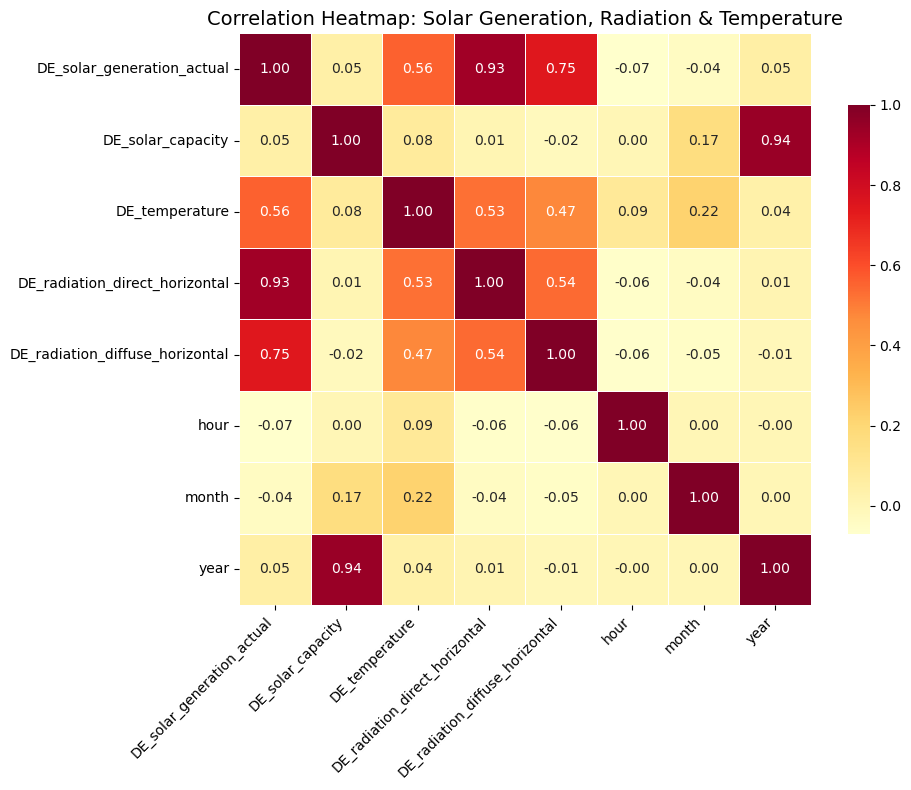

In [12]:
# Create heatmap of correlations between solar generation, radiation and temperature
plt.figure(figsize=(10, 8))
sns.heatmap(corr_solar, annot=True, cmap='YlOrRd', fmt='.2f', square=True,
            cbar_kws={"shrink": .75}, linewidths=.5)
plt.title('Correlation Heatmap: Solar Generation, Radiation & Temperature', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

The correlation heatmap shows relationships between solar production, capacity, temperature, and radiation.  

- DE_solar_generation_actual is strongly correlated with direct radiation (0.93) and moderately with diffuse radiation (0.75), highlighting the importance of sunlight.  
- It also shows a moderate correlation with temperature (0.56).  
- Solar capacity has almost no correlation, suggesting it does not affect daily fluctuations.  
- Hour, month, and year show only weak correlations compared to radiation and temperature.


#### 4.1.2 Time Series Plot: Solar Production from 2015 - 2019

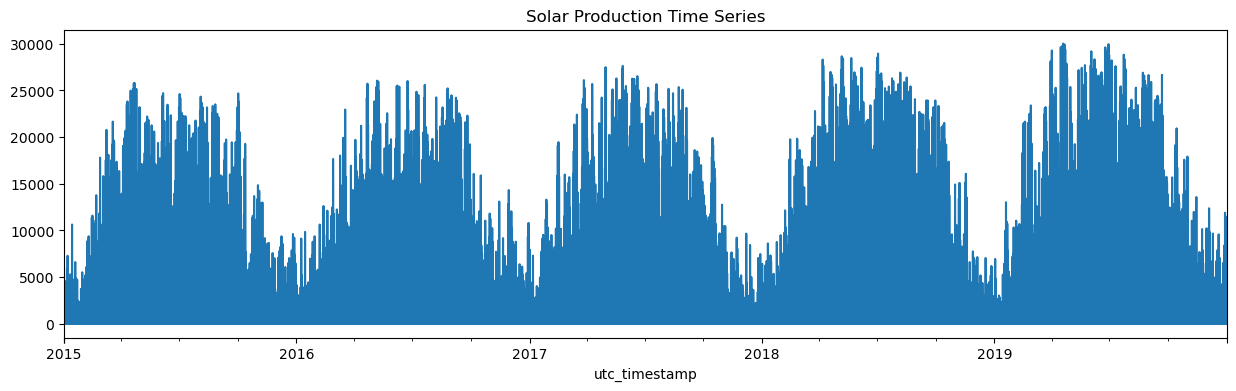

In [13]:
# Create plot displaying solar production from 2015 - 2019
solar_merged['DE_solar_generation_actual'].plot(figsize=(15,4), title='Solar Production Time Series')
plt.show()

The figure shows hourly solar power production (MW) in Germany between 2015 and 2019.  A clear seasonal pattern can be observed: during the summer months, solar production regularly peaks at over 30,000 MW, while in the winter months it drops significantly. This highlights the strong dependence of solar power generation on sunlight availability and seasonal variations.

#### 4.1.2 Time Series Plot: Mean Solar Generation per Day

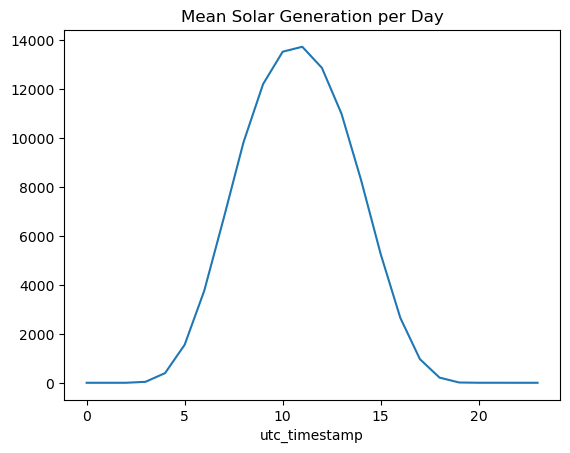

In [14]:
# Create plot displaying the mean solar production per day
solar_merged.groupby(solar_merged.index.hour)['DE_solar_generation_actual'].mean().plot(title='Mean Solar Generation per Day')
plt.show()

The plot shows a clear bell-shaped curve for mean daily solar generation, with peak production occurring around hour 11-12 (midday). Solar generation begins to rise sharply after hour 5 (early morning), reaches its maximum of approximately 14,000 units at solar noon, and then symmetrically decreases through the afternoon, returning to near-zero values after hour 20 (evening). This pattern perfectly reflects the natural solar cycle, confirming that the solar generation data follows expected diurnal patterns.


#### 4.1.3 Time Series Plot: Mean Solar Generation per Month

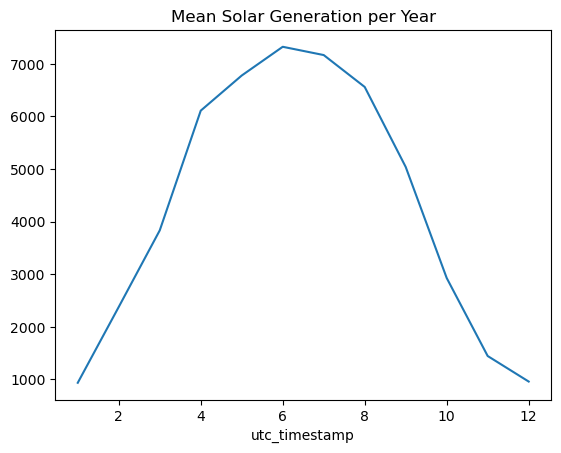

In [15]:
solar_merged.groupby(solar_merged.index.month)['DE_solar_generation_actual'].mean().plot(title='Mean Solar Generation per Year')
plt.show()

This diagram shows the average solar output over the course of a year.  
It illustrates that solar energy production is significantly higher during the summer months compared to the winter months. Not surprisingly, the pattern reflects the seasonal differences in solar radiation.

## 5. Data Preparation for Creation of Model

This section prepares the data for LSTM modeling. Relevant features and the target variable are selected and normalized using MinMax scaling. A sliding window approach is applied to generate sequences of 24-hour inputs and corresponding 24-hour outputs, creating arrays suitable for sequential learning. The dataset is then split into training, validation, and test sets, and a sample sequence is visualized to illustrate how past feature values relate to future solar generation.

In [16]:
# Definition of features and target
solar_merged.columns
X = solar_merged[['DE_temperature','DE_radiation_direct_horizontal', 'DE_radiation_diffuse_horizontal','hour', 'month', 'DE_solar_capacity']]
y = solar_merged['DE_solar_generation_actual']


### 5.1 Normalization of Data 

In [17]:
# Normalization of data 
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1,1))

In [18]:
# Create lists to hold sequences of X and y
X = []
y = []

# Total number of data points in the merged dataset
total_size = len(solar_merged)

# Length of input sequence for LSTM: 24 hours
sequence_length = 24

# Length of output sequence to predict: 24 hours
forecast_length = 24
sequence_step = 1 

# Create input/output pairs using a sliding window
# Input sequence: previous 'sequence_length' hours of features
# Output sequence: next 'forecast_length' hours of target variable

for i in range(sequence_length, total_size-forecast_length, sequence_step):
    X.append(X_scaled[i-sequence_length:i, :])
    y.append(y_scaled[i:i+forecast_length, 0])

# Convert to numpy arrays for model training
X = np.array(X)
y = np.array(y)

In [19]:
# Check shape of X
X.shape

(43777, 24, 6)

In [20]:
# Check shape of y
y.shape

(43777, 24)

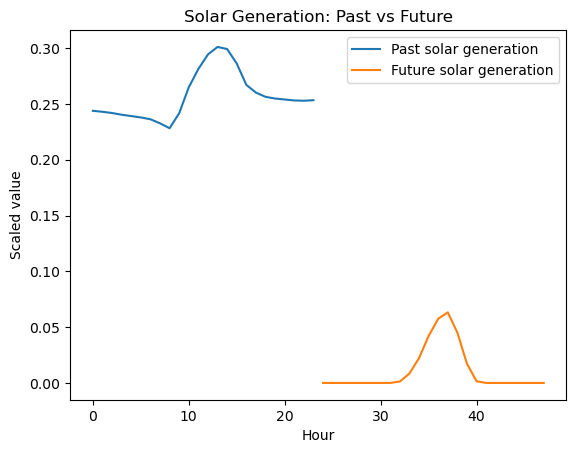

In [21]:
# Visualize a sequence from X and y

# Plot the input sequence of the target feature (e.g. solar generation)
plt.plot(range(24), X[0][:, 0], label='Past solar generation')  
# Plot the target sequence (next 24 hours)
plt.plot(range(24, 48), y[0], label='Future solar generation')

plt.xlabel('Hour')
plt.ylabel('Scaled value')
plt.title('Solar Generation: Past vs Future')
plt.legend()
plt.show()

This plot shows one example of how the input (past) and target (future) sequences are structured for the LSTM model. The blue curve represents the previous 24 hours of scaled solar generation, while the orange curve represents the following 24 hours that the model is trained to predict. It illustrates the sliding window setup used for forecasting.

In [22]:
# Split off test data
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

# Split into training and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, shuffle=False)

## 6. Modelling Approach: LSTM

This section implements an LSTM model to forecast solar power generation. LSTMs are particularly suitable for time series forecasting because they can capture temporal dependencies and patterns over long sequences. Unlike traditional neural networks, LSTMs can retain information from previous time steps, making them effective for predicting solar power generation.

#### Initial architecture:
- LSTM(100) → LSTM(100) → Dense(100) → Dense(24)
- Loss: MSE, optimizer: Adam, learning rate: 0.001,  number of epochs: 20, batch size: 32


Model performance is evaluated using mean squared error (MSE) and R² metrics on both training and validation sets.


#### Hyperparameter tuning: 
- LSTM(150), dropout: 0.3 -> LSTM(150), dropout: 0.3 -> Dense(100) -> Dense(24)
- Loss: MSE, optimizer: Adam, learning rate: 0.001,  number of epochs: 20, batch size: 16


Finally, the predicted solar power values are converted back to their original scale and compared with the actual values to assess how well the model forecasts.

### 6.1 Initialisation of LSTM Model

In [23]:
# Initialise model: LSTM(100) -> LSTM(100) -> Dense(100) -> Dense(24), no dropout

model = keras.models.Sequential()
model.add(keras.layers.Input((X_train.shape[1:])))
model.add(keras.layers.LSTM(100,
                            recurrent_dropout=0.0,
                            return_sequences=True))
model.add(keras.layers.LSTM(100,
                            recurrent_dropout=0.0,
                            return_sequences=False))
model.add(keras.layers.Dense(100,
                             activation='tanh'))
model.add(keras.layers.Dense(forecast_length,
                             activation='linear'))

In [24]:
# Compile model using Adam optimizer and MSE loss function
optimizer = keras.optimizers.Adam(learning_rate=0.001)  
model.compile(loss='mse', optimizer=optimizer,  
              metrics=['r2_score'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 100)        │        42,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 24)             │         2,424 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 135,724 (530.17 KB)

 Trainable params: 135,724 (530.17 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# Fit model
history = model.fit(X_train, y_train, epochs = 20, batch_size = 32, validation_data = (X_val, y_val))

Epoch 1/20
985/985 ━━━━━━━━━━━━━━━━━━━━ 29s 26ms/step - loss: 0.0058 - r2_score: 0.8740 - val_loss: 0.0063 - val_r2_score: 0.8868
Epoch 2/20
985/985 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - loss: 0.0040 - r2_score: 0.9139 - val_loss: 0.0056 - val_r2_score: 0.8994
Epoch 3/20
985/985 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - loss: 0.0037 - r2_score: 0.9203 - val_loss: 0.0054 - val_r2_score: 0.9036
Epoch 4/20
985/985 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - loss: 0.0036 - r2_score: 0.9227 - val_loss: 0.0064 - val_r2_score: 0.8852
Epoch 5/20
985/985 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - loss: 0.0034 - r2_score: 0.9257 - val_loss: 0.0055 - val_r2_score: 0.9012
Epoch 6/20
985/985 ━━━━━━━━━━━━━━━━━━━━ 27s 28ms/step - loss: 0.0033 - r2_score: 0.9274 - val_loss: 0.0055 - val_r2_score: 0.9017
Epoch 7/20
985/985 ━━━━━━━━━━━━━━━━━━━━ 27s 28ms/step - loss: 0.0033 - r2_score: 0.9289 - val_loss: 0.0057 - val_r2_score: 0.8987
Epoch 8/20
985/985 ━━━━━━━━━━━━━━━━━━━━ 28s 28ms/step - loss: 0.0032 - r2_score: 0.9310 - 

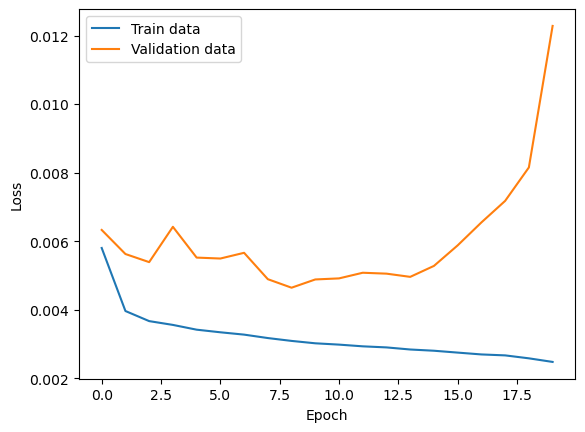

In [26]:
# Plot learning rates
history = history.history
plt.plot(history['loss'], label='Train data')
plt.plot(history['val_loss'], label='Validation data')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

This plot shows the training and validation loss curves over 20 epochs. While the training loss decreases steadily, the validation loss fluctuates, suggesting that the model begins to overfit. The model performs well on the training set but struggles to make accurate predictions on new data.

### 6.2  Evaluation of Initial Model

In [27]:
# Predict train and validation sets
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

985/985 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


In [28]:
# Rescaling of actual and predicted values
y_train_rescaled = scaler_y.inverse_transform(y_train)
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)

y_val_rescaled = scaler_y.inverse_transform(y_val)
y_val_pred_rescaled = scaler_y.inverse_transform(y_val_pred)

In [29]:
# Calculation of MSE and R2 metrics

# Training data
mse_train_1 = mean_squared_error(y_train_rescaled, y_train_pred_rescaled)
r2_train_1 = r2_score(y_train_rescaled, y_train_pred_rescaled)

# Validation data
mse_val_1 = mean_squared_error(y_val_rescaled, y_val_pred_rescaled)
r2_val_1 = r2_score(y_val_rescaled, y_val_pred_rescaled)

In [55]:
round(mse_train_1)

2162283

In [31]:
round(r2_train_1, 2)

0.95

In [54]:
round(mse_val_1)

11072793

In [33]:
round(r2_val_1, 2)

0.78

Performance of initial model: 

- Training set: MSE = 2162283,  R² = 0.95
- Validation set: MSE = 11072793, R² = 0.78


The initial model fits the training data extremely well (R² = 0.95) but shows a significant performance drop on the validation set (R² = 0.78). This gap between training and validation metrics points to overfitting. 

### 6.3 Visualisation: Prognosis vs. Actual Data

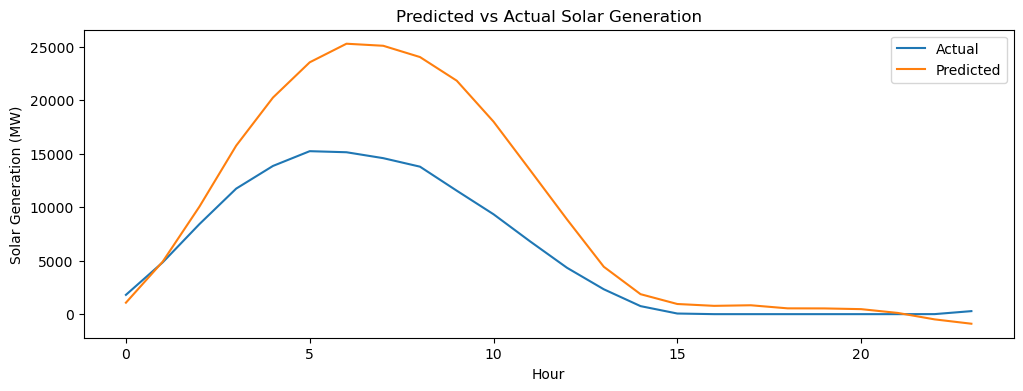

In [34]:
# Randomly select a validation sample index
index = np.random.randint(len(X_val))

# Visualize predictions vs actual for a random validation sample
plt.figure(figsize=(12, 4))
plt.plot(range(forecast_length), y_val_rescaled[index], label='Actual')
plt.plot(range(forecast_length), y_val_pred_rescaled[index], label='Predicted')
plt.xlabel('Hour')
plt.ylabel('Solar Generation (MW)')
plt.title('Predicted vs Actual Solar Generation')
plt.legend()
plt.show()

This plot shows predicted vs. actual solar generation over the period of 24 hours. The model successfully captures the solar generation over the course of the 24 hours, peaking before midday and declining toward evening, but it consistently overestimates generation values, especially during peak hours. This suggests the model has learned the general pattern but struggles with accurately predicting the magnitude of solar power generation.

### 6.4 Hyperparameter Tuning: Updated Model

The model is updated by increasing the first LSTM layer to 150 neurons (instead of 100), adding a dropout rate of 0.3 to both LSTM layers, and reducing the batch size to 16.

In [35]:
# Initialise model: first LSTM layer 150 neurons instead of 100, batch_size reduced to 16, dropout = 0.3 
# in both LSTM layers

model = keras.models.Sequential()
model.add(keras.layers.Input((X_train.shape[1:])))
model.add(keras.layers.LSTM(150,
                            recurrent_dropout=0.0,
                            dropout=0.3,
                            return_sequences=True))
model.add(keras.layers.LSTM(100,
                            recurrent_dropout=0.0,
                            dropout=0.3,
                            return_sequences=False))
model.add(keras.layers.Dense(100,
                             activation='tanh'))
model.add(keras.layers.Dense(forecast_length,
                             activation='linear'))

In [36]:
# Compile model
optimizer = keras.optimizers.Adam(learning_rate=0.001)  
model.compile(loss='mse', optimizer=optimizer,  
              metrics=['r2_score'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 24, 150)        │        94,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 100)            │       100,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 24)             │         2,424 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 207,124 (809.08 KB)

 Trainable params: 207,124 (809.08 KB)

 Non-trainable params: 0 (0.00 B)

In [37]:
# Fit model
history = model.fit(X_train, y_train, epochs = 20, batch_size = 16, validation_data = (X_val, y_val))

Epoch 1/20
1970/1970 ━━━━━━━━━━━━━━━━━━━━ 55s 27ms/step - loss: 0.0098 - r2_score: 0.7879 - val_loss: 0.0085 - val_r2_score: 0.8487
Epoch 2/20
1970/1970 ━━━━━━━━━━━━━━━━━━━━ 53s 27ms/step - loss: 0.0068 - r2_score: 0.8518 - val_loss: 0.0178 - val_r2_score: 0.6818
Epoch 3/20
1970/1970 ━━━━━━━━━━━━━━━━━━━━ 53s 27ms/step - loss: 0.0061 - r2_score: 0.8682 - val_loss: 0.0097 - val_r2_score: 0.8271
Epoch 4/20
1970/1970 ━━━━━━━━━━━━━━━━━━━━ 54s 27ms/step - loss: 0.0055 - r2_score: 0.8808 - val_loss: 0.0130 - val_r2_score: 0.7674
Epoch 5/20
1970/1970 ━━━━━━━━━━━━━━━━━━━━ 54s 27ms/step - loss: 0.0052 - r2_score: 0.8879 - val_loss: 0.0099 - val_r2_score: 0.8222
Epoch 6/20
1970/1970 ━━━━━━━━━━━━━━━━━━━━ 54s 27ms/step - loss: 0.0049 - r2_score: 0.8928 - val_loss: 0.0093 - val_r2_score: 0.8345
Epoch 7/20
1970/1970 ━━━━━━━━━━━━━━━━━━━━ 55s 28ms/step - loss: 0.0048 - r2_score: 0.8964 - val_loss: 0.0085 - val_r2_score: 0.8476
Epoch 8/20
1970/1970 ━━━━━━━━━━━━━━━━━━━━ 55s 28ms/step - loss: 0.0046 - r2_

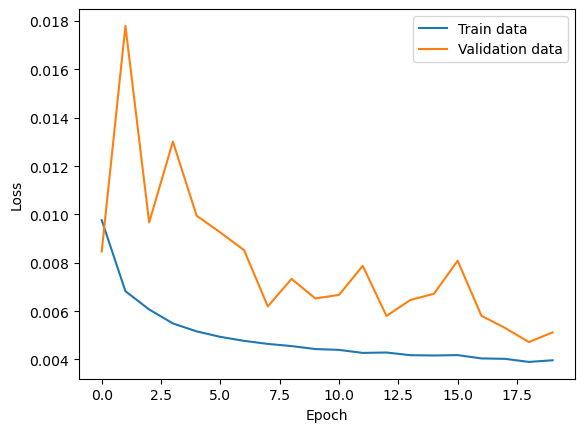

In [38]:
# Plot learning rates
history = history.history
plt.plot(history['loss'], label='Train data')
plt.plot(history['val_loss'], label='Validation data')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In this updated model, the training loss decreases steadily and flattens out, showing that the model is learning consistently. On average, the validation loss is higher than the training loss, suggesting that the model fits the training data better than the validation set, but it does not show clear overfitting — rather, it seems noisy and sensitive to the validation samples.

### 6.5 Evaluation of Updated Model

In [39]:
# Predict train and validation sets
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

985/985 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step


In [40]:
# Rescaling of actual and predicted values
y_train_rescaled = scaler_y.inverse_transform(y_train)
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)

y_val_rescaled = scaler_y.inverse_transform(y_val)
y_val_pred_rescaled = scaler_y.inverse_transform(y_val_pred)

In [41]:
# Calculation of MSE and R2 metrics

# Training data
mse_train_2 = mean_squared_error(y_train_rescaled, y_train_pred_rescaled)
r2_train_2 = r2_score(y_train_rescaled, y_train_pred_rescaled)

# Validation data
mse_val_2 = mean_squared_error(y_val_rescaled, y_val_pred_rescaled)
r2_val_2 = r2_score(y_val_rescaled, y_val_pred_rescaled)

In [53]:
round(mse_train_2)

3908036

In [43]:
round(r2_train_2, 2)

0.91

In [52]:
round(mse_val_2)

4618790

In [45]:
round(r2_val_2, 2)

0.91

Performance of updated model: 

- Training set: MSE = 3908036,  R² = 0.91
- Validation set: MSE = 4618790, R² = 0.91

The updated model slightly increases training error but greatly improves validation performance, with training and validation R² both at 0.91. This indicates it generalizes well without overfitting.


### 6.6 Final Evaluation

In [48]:
# Use the test set for final evaluation
y_test_pred = model.predict(X_test)
y_test_rescaled = scaler_y.inverse_transform(y_test)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)

# Final test metrics
mse_test = mean_squared_error(y_test_rescaled, y_test_pred_rescaled)
r2_test = r2_score(y_test_rescaled, y_test_pred_rescaled)

137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


In [51]:
round(mse_test)

3867718

In [50]:
round(r2_test, 2)

0.92

The final evaluation reveals that the model performs reliably on completely unseen data. 
and the test performance (R² = 0.92) is actually better than the model's performance on training and validation data and shows no signs of overfitting. 

## 7. Conclusion and Outlook


## Conclusion


This project explored the use of weather data, particularly solar radiation and temperature, to forecast solar power generation for a 24-hour horizon in Germany using an LSTM model.  Weather data, especially direct radiation, strongly influences solar power generation in Germany, and LSTM models effectively capture the resulting temporal, diurnal, and seasonal patterns.

The initial LSTM model captured general trends well (R² = 0.95 on training data) but struggles with the validation data (R² = 0.78) which indicates overfitting. After adjusting several model parameters, the updated model showed improved generalization, achieving R² = 0.91 on both training and validation sets, with a substantial reduction in MSE on the validation data. This suggests the updated model balances fit and generalization effectively, providing more reliable forecasts.

The final evaluation on unseen test data confirms the model's robust performance, achieving R² = 0.92 and MSE = 3,867,718.15. This test performance actually surpasses both training and validation metrics, demonstrating excellent generalization capability with no signs of overfitting.

These results demonstrate the model's suitability for real-world deployment in grid operations and energy trading applications. 

| Model          | Dataset        | MSE          | R²   |
|----------------|----------------|--------------|------|
| Initial Model  | Training       | 2,162,283    | 0.95 |
| Initial Model  | Validation     | 11,072,792   | 0.78 |
| Updated Model  | Training       | 3,908,036    | 0.91 |
| Updated Model  | Validation     | 4,618,789    | 0.91 |
| Updated Model  | Test           | 3,867,718    | 0.92 |


## Limitations:

This project is limited to Germany, so the results may not generalize to other countries with different weather patterns. In addition to that, only a 24-hour forecast horizon was considered, which restricts the model to short-term predictions. Lastly, the model relies on solar radiation and temperature only, omitting other potentially important features such as cloud coverage or wind speed.

## Future Work

Future work could aim at further optimising the current model with respect to dropout outside the LSTM layers, including early stopping or L2 regularisation. 
In addition to that, alternative modeling approaches such as Transformer-based architectures, Gradient Boosted Trees or classic regression models could be explored. Furthermore, investigating Bayesian neural networks for uncertainty quantification or 1D Convolutional networks for the extraction of features could further enhance predictive performance. 
Future work could also address some of the limitations mentioned above, such as extending the forecast horizon, incorporating additional weather features like cloud coverage or wind speed, and evaluating the model on data from other countries.
